# Análisis Espacial para Selección de Municipio y Área Óptima (Nivel 1 y 2)
**Curso:** Programación SIG. Universidad Nacional de Colombia. Facultad de Ciencias Agrarias.  
**Autor:** Daniela Rayo Álvarez  
**Fecha:** 2025-06-17  

## Objetivos

* Desarrollar un análisis espacial reproducible y estructurado para seleccionar el municipio más adecuado para implementar un proyecto territorial (p. ej., cultivo, escuela, hospital).
* Aplicar operaciones espaciales avanzadas basadas en vectores (intersecciones, buffers, uniones espaciales, normalización de variables) a datos geográficos de Colombia.
* Integrar múltiples fuentes de información (producción agropecuaria, estaciones IDEAM, infraestructura vial, áreas protegidas) en un análisis multicriterio.
* Identificar y mapear la **mejor zona local dentro del municipio seleccionado**, considerando al menos tres criterios espaciales locales.
* Reforzar la capacidad de interpretar resultados espaciales, realizar visualizaciones cartográficas y justificar decisiones basadas en datos geográficos.

> Este proyecto culmina con una salida final que incluye:
> - El **municipio óptimo** seleccionado.
> - La **zona local óptima** (≤ 5 km²) dentro de dicho municipio.
> - Mapas que muestran las capas y pasos intermedios clave.


## Prerrequisitos

Este cuaderno requiere los siguientes conjuntos de datos para realizar el análisis espacial multinivel

| Archivo | Descripción | CRS / Campos clave |
|--------|-------------|--------------------|
| `municipios_colombia.shp` | Polígonos de municipios de Colombia | EPSG:3116 (MAGNA‑Sirgas / Colombia Bogotá); `MPIO_CCDGO` |
| `Vias_Colombia.shp` | Red vial nacional (carreteras principales y secundarias) | EPSG:3116; geometría lineal |
| `runap.shp` | Áreas naturales protegidas (RUNAP) | EPSG:3116; geometría poligonal |
| `Catalogo_Estaciones_IDEAM.csv` | Catálogo de estaciones meteorológicas del IDEAM (latitud, longitud, altitud) | EPSG:4326 (WGS 84); columnas `Ubicación`, `ID` |
| `Evaluaciones_Agropecuarias_Municipales_EVA.csv` | Estadísticas de producción agrícola municipal (por cultivo) | Campos: `CULTIVO`, `Producción\n(t)`, `CÓD. MUN.` |

## Introducción

Las operaciones espaciales nos permiten responder preguntas clave relacionadas con la ubicación, como por ejemplo:  
*¿Qué municipios están dentro de cierta distancia de una carretera?*  
*¿Qué estación climática está más cerca de una zona de cultivo?*

Estas operaciones se dividen en dos grandes categorías:

- **Operaciones espaciales**: Evalúan relaciones topológicas entre objetos geográficos (como `intersects`, `within`, `contains`), permitiéndonos combinar capas vectoriales con lógica espacial.
- **Operaciones geométricas**: Transforman o generan nuevas geometrías, como buffers (zonas de influencia), intersecciones, diferencias espaciales o recortes.

## Configuración inicial y carga de datos

## Librerías utilizadas

| Librería | Uso principal |
|----------|---------------|
| `geopandas` | Análisis de datos espaciales (shapefiles, geometrías, operaciones como `intersects`, `buffer`, etc.) |
| `pandas` | Manipulación de datos tabulares (CSV, filtros, agrupaciones) |
| `matplotlib.pyplot` | Visualización de gráficos y mapas |
| `Line2D`, `mpatches` | Personalización de leyendas en mapas |
| `numpy` | Cálculos numéricos y generación de grillas |
| `shapely` | Creación y manipulación de geometrías (puntos, polígonos, buffers) |
| `MinMaxScaler` | Normalización de variables entre 0 y 1 |
| `contextily` | Agregado de mapas base (tiles) a gráficos espaciales |


In [27]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import numpy as np
import shapely
from shapely.geometry import Point, box
from sklearn.preprocessing import MinMaxScaler
import contextily as ctx

In [28]:
# Definir rutas
root_folder = "/notebooks/documentos"
SHAPE_MUN = root_folder + '/municipios_colombia.shp'
EVA_CSV   = root_folder + '/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder + '/Catalogo_Estaciones_IDEAM.csv'
VIAS      = root_folder + '/Vias_Colombia.shp'
runap     = root_folder + '/runap.shp'

In [29]:
print(SHAPE_MUN)
print(EVA_CSV)
print(EST_CSV)
print(VIAS)
print(runap)

/notebooks/documentos/municipios_colombia.shp
/notebooks/documentos/Evaluaciones_Agropecuarias_Municipales_EVA.csv
/notebooks/documentos/Catalogo_Estaciones_IDEAM.csv
/notebooks/documentos/Vias_Colombia.shp
/notebooks/documentos/runap.shp


## Paso 1: Preparación de datos y CRS

Este bloque carga todos los archivos necesarios y los transforma al sistema de coordenadas común **EPSG:9377**

### ¿Qué es EPSG:9377?

El código **EPSG:9377** corresponde a un sistema de coordenadas proyectado específico para Colombia, conocido como:

> **MAGNA-SIRGAS / Origen Nacional (metros)**

#### Características principales:
- **Sistema de referencia geodésico**: SIRGAS (Sistema de Referencia Geocéntrico para las Américas).
- **Unidad**: metros.
- **Tipo**: sistema proyectado, adecuado para realizar cálculos espaciales (distancias, áreas, buffers).
- **Zona de uso**: diseñado específicamente para todo el territorio colombiano, con cobertura nacional homogénea.
- **Proyección**: Transversa de Mercator (como UTM, pero ajustada a Colombia).

#### ¿Por qué se usa en este proyecto?
- **Recomendado por el IGAC** (Instituto Geográfico Agustín Codazzi) para análisis geoespacial a nivel nacional.
- **Evita errores** en cálculos métricos (como longitud de vías o área de polígonos) que ocurren con sistemas geográficos como EPSG:4326 (lat/lon).
- **Unifica el sistema de referencia** entre todas las capas (municipios, vías, estaciones, áreas protegidas).

>  Transformar todos los datos al CRS **EPSG:9377** es un paso obligatorio para garantizar precisión y coherencia en el análisis espacial.


In [30]:
# Municipios
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)

# Vías
gdf_vias = gpd.read_file(VIAS).to_crs(epsg=9377)

# RUNAP
gdf_runap = gpd.read_file(runap).to_crs(epsg=9377)

# EVA
eva = pd.read_csv(EVA_CSV).rename(columns={"CÓD. MUN.": "cod_mun"})
eva["cod_mun"] = eva["cod_mun"].astype(str).str.zfill(5)

# Estaciones IDEAM
df_est = pd.read_csv(EST_CSV, encoding="latin1", sep=';')
coords = df_est["Ubicación"].str.strip("()").str.split(",", expand=True).astype(float)
df_est["lat"], df_est["lon"] = coords[0], coords[1]
gdf_est = gpd.GeoDataFrame(df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326").to_crs(epsg=9377)

print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows • {len(gdf_vias):,} vias • {len(gdf_runap):,} runap")

# Homogeneizar códigos
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)


1,122 municipalities • 8,973 stations • 206,068 EVA rows • 108,228 vias • 1,785 runap


## Paso 2: Criterios de análisis a nivel municipal

### 2.1 - Número de estaciones IDEAM por municipio

### Funciones clave

- **`gpd.sjoin(...)`**  
  Realiza una **unión espacial** entre las estaciones (`gdf_est`) y los municipios (`gdf_mun`), combinando atributos cuando las geometrías cumplen una relación espacial.

- **`predicate='within'`**  
  Especifica la condición espacial: selecciona solo aquellas estaciones **que están contenidas dentro** del polígono de un municipio.

- **`geometry`**  
  Columna especial que almacena las **formas espaciales** (puntos, líneas o polígonos) y permite evaluar relaciones espaciales como `within`, `intersects`, etc.

- **`.size()`**  
  Cuenta cuántas estaciones hay por cada municipio (cantidad de filas por grupo). Es útil para saber, por ejemplo, cuántos puntos cayeron dentro de cada polígono.

- **`.reset_index(name='ideam_count')`**  
  Convierte el resultado de `.groupby().size()` en un `DataFrame` estructurado, con:
  - Una columna con los códigos de municipio.
  - Una columna llamada `ideam_count` que contiene el número de estaciones por municipio.



In [31]:
stations_per_mun = gpd.sjoin(gdf_est, gdf_mun[['MPIO_CCDGO', 'geometry']], predicate='within')
est_counts = stations_per_mun.groupby("MPIO_CCDGO").size().reset_index(name='ideam_count')

#print("Resultado de la unión espacial (stations_per_mun):")
#print(stations_per_mun)
#print("Conteo de estaciones por municipio (est_counts):")
#print(est_counts)

### 2.2 - Densidad de vías por municipio

### Funciones clave

- **`geopandas.overlay`**  
  Realiza una **superposición espacial** entre dos `GeoDataFrame`.

  - **Soporta**: Geometrías uniformes (solo polígonos, puntos o líneas).
  - **Parámetro principal `how`**:
    - `'intersection'` (solo las partes comunes entre ambas capas),
    - `'union'` (todas las geometrías combinadas de ambas capas),
    - `'identity'` (todo `df1` con atributos añadidos de `df2` donde se superponen),
    - `'symmetric_difference'` (las partes que no se superponen entre `df1` y `df2`),
    - `'difference'` (partes de `df1` que no se superponen con `df2`).

  **Parámetros opcionales**:
  - `keep_geom_type`: Mantiene el tipo de geometría de `df1` (`True` por defecto).
  - `make_valid`: Corrige geometrías inválidas (`True` por defecto).

  **Retorna**:
  - Un nuevo `GeoDataFrame` con las geometrías y atributos resultantes.

- **`.geometry.length`**  
  Calcula la **longitud de cada geometría lineal** (como carreteras) en unidades del sistema de coordenadas.  
  Como estamos usando **EPSG:9377** (metros), devuelve la longitud en **metros**.

In [88]:
# Intersecar vías con municipios
vias_in_mun = gpd.overlay(gdf_vias, gdf_mun[["MPIO_CCDGO", "geometry"]], how='intersection')
print(f"Vías intersectadas con municipios: {len(vias_in_mun)} segmentos")

# Paso 1: calcular longitud individual de cada línea (en metros)
vias_in_mun['length_m'] = vias_in_mun.geometry.length
print("Longitudes individuales calculadas.")

# Paso 2: sumar longitudes por municipio
vias_length = vias_in_mun.groupby("MPIO_CCDGO")['length_m'].sum().reset_index()
print(f"Longitudes agregadas por municipio: {vias_length.shape[0]} municipios")

Vías intersectadas con municipios: 121525 segmentos
Longitudes individuales calculadas.
Longitudes agregadas por municipio: 577 municipios


### 2.3 - Producción de avocado por municipio

### Funciones clave

- **`.str.upper()`**
Convierte texto a **mayúsculas**. Útil para comparar cadenas sin importar su formato original.

- **`.rename({...})`**
Renombra columnas para que sean más claras o compatibles con otras tablas.

- **`.sort_values(by=..., ascending=False)`**
Ordena el `DataFrame` por una columna, de mayor a menor.

- **`.reset_index(drop=True)`**
Reinicia el índice después de ordenar, eliminando el anterior.

In [65]:
# Filtrar registros de avocado (ignorando mayúsculas/minúsculas)
avocado_eva = eva[eva["CULTIVO"].str.upper() == "AGUACATE"]
print(f"Registros de avocado encontrados: {len(avocado_eva)}")

# Agrupar y sumar la producción por municipio
avocado_prod = (
    avocado_eva.groupby("cod_mun")["Producción\n(t)"]
    .sum()
    .reset_index()
    .rename(columns={"cod_mun": "MPIO_CCDGO", "Producción\n(t)": "avocado_prod_ton"})
)

# Ordenar por producción descendente
avocado_prod = avocado_prod.sort_values(by="avocado_prod_ton", ascending=False).reset_index(drop=True)

print(f"Producción agregada por municipio: {avocado_prod.shape[0]} municipios")

# Vista previa de resultados
print(avocado_prod.head())

Registros de avocado encontrados: 4542
Producción agregada por municipio: 553 municipios
  MPIO_CCDGO  avocado_prod_ton
0      13244            299454
1      73283            294564
2      73443            137749
3      05847            133408
4      05756             78261


### 2.4 - Población interpolada por municipio (ejemplo usando área como proxy)

La propiedad `.area` en GeoPandas calcula el **área de cada geometría** en un `GeoDataFrame`.

- Se aplica directamente sobre la columna `geometry`.
- El valor resultante está en **las unidades del sistema de coordenadas (CRS)**.  

In [50]:
# Calcular área de cada municipio
gdf_mun['area_m2'] = gdf_mun.area
gdf_mun['population'] = gdf_mun['area_m2'] / 1e6  # Proxy: 1 persona por km²
# View sample
gdf_mun[['MPIO_CNMBR', 'area_m2', 'population']].head()

,MPIO_CNMBR,area_m2,population
0,FLORENCIA,2.546958e+09,2546.958298
1,ALBANIA,4.141007e+08,414.100691
2,BELÉN DE LOS ANDAQUÍES,1.191551e+09,1191.551389
3,EL DONCELLO,1.105515e+09,1105.514836
4,EL PAUJÍL,1.234141e+09,1234.140645


In [58]:
# Superposición municipio-grilla
mun_grid = gpd.overlay(
    gdf_mun[['MPIO_CCDGO', 'area_m2', 'population', 'geometry']],
    grid
)
mun_grid['area_sub'] = mun_grid.area
mun_grid.head()


,MPIO_CCDGO,area_m2,population,grid_id,geometry,area_sub
0,00001,2.546958e+09,2546.958298,38,"POLYGON ((4730891.264 1800687.527, 4730982.048...",8.540306e+07
1,00001,2.546958e+09,2546.958298,39,"POLYGON ((4733986.939 1790054.988, 4733960.326...",2.461555e+09
2,00029,4.141007e+08,414.100691,39,"POLYGON ((4677934.064 1709133.8, 4677934.101 1...",2.824512e+08
3,00029,4.141007e+08,414.100691,40,"POLYGON ((4693057.163 1690081.8, 4693088.62 16...",1.316495e+08
4,00094,1.191551e+09,1191.551389,39,"POLYGON ((4690005.125 1751582.406, 4689993.69 ...",1.190663e+09


In [61]:
# Cálculos de proporción de área y población por celda
mun_grid['area_sub'] = mun_grid.area
mun_grid['area_prop'] = mun_grid['area_sub'] / mun_grid['area_m2']
mun_grid['population_part'] = mun_grid['population'] * mun_grid['area_prop']

# Agrupar población por municipio
pop_by_mun = mun_grid.groupby("MPIO_CCDGO")['population_part'].sum().reset_index()
print(f"Población redistribuida agregada por municipio: {pop_by_mun.shape[0]} municipios")
print(pop_by_mun.head())

Población redistribuida agregada por municipio: 581 municipios
  MPIO_CCDGO  population_part
0      00001    107206.338608
1      00002       506.952804
2      00003      1379.898716
3      00004       296.974188
4      00006      3411.725411


## Paso 3: Multi-criterio y ranking final

In [66]:
# Unión de métricas
mun_scores = gdf_mun[['MPIO_CCDGO', 'MPIO_CNMBR', 'area_m2']].copy()
mun_scores = mun_scores.merge(est_counts, on='MPIO_CCDGO', how='left')
mun_scores = mun_scores.merge(vias_length, on='MPIO_CCDGO', how='left')
mun_scores = mun_scores.merge(avocado_prod, on='MPIO_CCDGO', how='left')
mun_scores = mun_scores.merge(pop_by_mun, on='MPIO_CCDGO', how='left')
mun_scores = mun_scores.fillna(0)
print(f"Datos combinados: {mun_scores.shape[0]} municipios con métricas unidas.")

# Normalización de variables
scaler = MinMaxScaler()
mun_scores[['C1_estaciones', 'C2_vias_km_km2', 'C3_avocado_prod', 'C4_poblacion']] = scaler.fit_transform(
    pd.DataFrame({
        'C1_estaciones': mun_scores['ideam_count'],
        'C2_vias_km_km2': mun_scores['length_m'] / (mun_scores['area_m2'] + 1e-6),
        'C3_avocado_prod': mun_scores['avocado_prod_ton'] / (mun_scores['area_m2'] + 1e-6),
        'C4_poblacion': mun_scores['population_part']
    }))
print("Normalización completada.")

# Puntaje compuesto
mun_scores['SCORE'] = (
    0.25 * mun_scores['C1_estaciones'] +
    0.25 * mun_scores['C2_vias_km_km2'] +
    0.25 * mun_scores['C3_avocado_prod'] +
    0.25 * mun_scores['C4_poblacion'])
print("Puntaje compuesto calculado.")

# Mostrar los 10 municipios con mayor score
top10 = mun_scores.sort_values('SCORE', ascending=False).head(10)
print("Top 10 municipios con mayor SCORE:")
print(top10[['MPIO_CCDGO', 'MPIO_CNMBR', 'SCORE']])

Datos combinados: 1122 municipios con métricas unidas.
Normalización completada.
Puntaje compuesto calculado.
Top 10 municipios con mayor SCORE:
     MPIO_CCDGO    MPIO_CNMBR     SCORE
628       00001    SAN ANDRÉS  0.750000
867       00001  AGUA DE DIOS  0.579481
637       00001         TUNJA  0.556989
256       00001       ARMENIA  0.555998
1061      00001   BUCARAMANGA  0.544613
466       00001  BARRANQUILLA  0.544193
602       00001     SINCELEJO  0.524330
282       00001      MEDELLÍN  0.518171
229       00001     MANIZALES  0.515445
16        00001       POPAYÁN  0.514175


## Nivel 2 — Selección intra-municipal (área óptima)

### 4.1 - Filtrar mejor municipio y crear grilla fina

In [70]:
mun_sel = gdf_mun[gdf_mun['MPIO_CDPMP'] == '88001'] 
print(mun_sel.shape)  # (1, n)

(1, 94)


In [81]:
# Crear buffer de 10 km alrededor del municipio seleccionado
mun_sel_general_buffer = mun_sel.copy()
mun_sel_general_buffer["geometry"] = mun_sel.geometry.buffer(10000)

# Estaciones dentro del buffer (intersección espacial)
estaciones_20km_mun_sel_general = gpd.sjoin(
    gdf_est,
    mun_sel_general_buffer,
    how='inner',
    predicate='intersects'
)

# Mostrar resultados
print(estaciones_20km_mun_sel_general.head())
print(f"Número de estaciones dentro de 20 km: {len(estaciones_20km_mun_sel_general)}")


          Codigo                                          Nombre  \
223     17019010                     SAN ANDRES - AUT [17019010]   
271     17015010              AEROPUERTO SESQUICENTEN [17015010]   
1952  1701500133  RADIO SONDA SAN ANDRES ISLA - AUT [1701500133]   
2781    17017020                           SAN ANDRES [17017020]   
2784    17010020                        HOYO SOPLADOR [17010020]   

                Categoria      Estado  \
223          Mareográfica      Activa   
271   Sinóptica Principal      Activa   
1952          Radio Sonda      Activa   
2781         Limnigráfica  Suspendida   
2784        Pluviométrica      Activa   

                                           Departamento  \
223   Archipiélago de San Andres, Providencia y Sant...   
271   Archipiélago de San Andres, Providencia y Sant...   
1952  Archipiélago de San Andres, Providencia y Sant...   
2781  Archipiélago de San Andres, Providencia y Sant...   
2784  Archipiélago de San Andres, Providencia y S

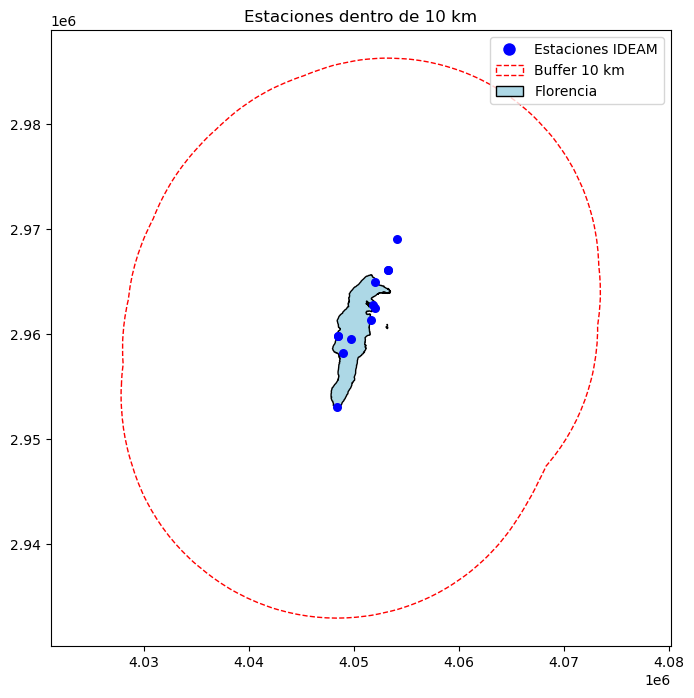

In [74]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot
mun_sel_general_buffer.plot(ax=ax, edgecolor='red', linestyle='--', facecolor='none')
mun_sel.plot(ax=ax, color='lightblue', edgecolor='black')
estaciones_20km_mun_sel_general.plot(ax=ax, color='blue', markersize=30)

# Zoom
xmin, ymin, xmax, ymax = mun_sel_general_buffer.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Estaciones IDEAM',
           markerfacecolor='blue', markersize=10),
    mpatches.Patch(edgecolor='red', facecolor='none', linestyle='--', label='Buffer 10 km'),
    mpatches.Patch(facecolor='lightblue', edgecolor='black', label='Mun_sel_general')
]
ax.legend(handles=legend_elements)

plt.title("Estaciones dentro de 10 km")
plt.axis('equal')
plt.show()

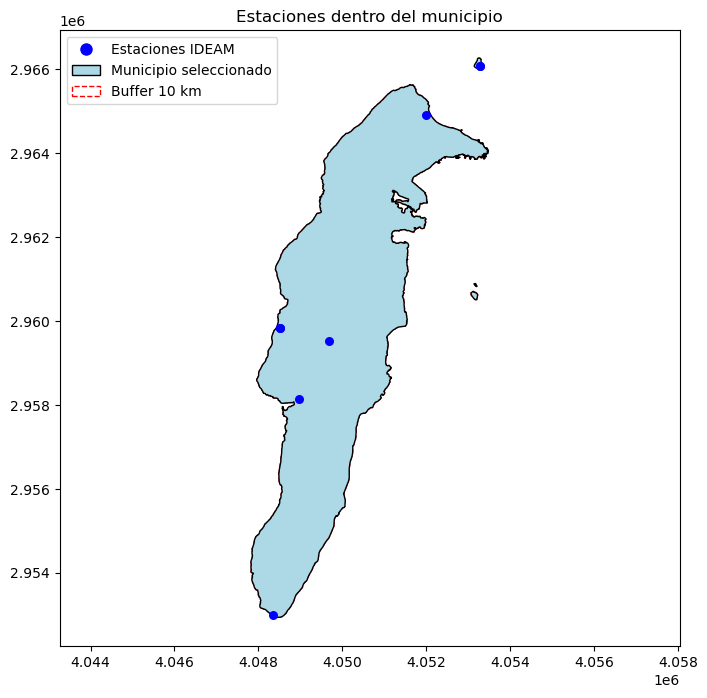

In [82]:
# 1. Recortar el buffer al municipio
mun_sel_general_buffer_dentro = gpd.overlay(mun_sel_general_buffer, mun_sel, how='intersection')

# 2. Obtener las estaciones dentro del municipio (usando clip para puntos dentro del polígono)
estaciones_dentro_municipio = estaciones_20km_mun_sel_general.clip(mun_sel)

# 3. Graficar
fig, ax = plt.subplots(figsize=(8, 8))

# Buffer recortado
mun_sel_general_buffer_dentro.plot(ax=ax, edgecolor='red', linestyle='--', facecolor='none')

# Municipio
mun_sel.plot(ax=ax, color='lightblue', edgecolor='black')

# Estaciones dentro del municipio
estaciones_dentro_municipio.plot(ax=ax, color='blue', markersize=30)

# Zoom al municipio
xmin, ymin, xmax, ymax = mun_sel.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Estaciones IDEAM',
           markerfacecolor='blue', markersize=10),
    mpatches.Patch(facecolor='lightblue', edgecolor='black', label='Municipio seleccionado'),
    mpatches.Patch(edgecolor='red', facecolor='none', linestyle='--', label='Buffer 10 km')
]
ax.legend(handles=legend_elements)

plt.title("Estaciones dentro del municipio")
plt.axis('equal')
plt.show()


In [42]:
# Intersecar RUNAP con el municipio seleccionado, conservando todas las geometrías
runap_in_mun = gpd.overlay(gdf_runap, gdf_mun, how='intersection', keep_geom_type=False)
print(f"Áreas protegidas (RUNAP) dentro del municipio: {len(runap_in_mun)}")

# Filtrar solo polígonos y multipolígonos para evitar líneas o geometrías inválidas
runap_in_mun = runap_in_mun[runap_in_mun.geometry.type.isin(['Polygon', 'MultiPolygon'])].reset_index(drop=True)
print(f"RUNAP filtrado a geometrías válidas (Polygon/MultiPolygon): {len(runap_in_mun)}")

# Quitar del grid las celdas que intersectan áreas protegidas
grid_fina_no_protegida = gpd.overlay(grid_fina, runap_in_mun, how='difference', keep_geom_type=False)
print(f"Celdas válidas fuera de áreas protegidas: {len(grid_fina_no_protegida)}")

# Asegurarse de mantener solo celdas poligonales tras la operación difference
grid_fina_no_protegida = grid_fina_no_protegida[
    grid_fina_no_protegida.geometry.type.isin(['Polygon', 'MultiPolygon'])
].reset_index(drop=True)
print(f"Celdas finales con geometrías válidas: {len(grid_fina_no_protegida)}")

Áreas protegidas (RUNAP) dentro del municipio: 2905
RUNAP filtrado a geometrías válidas (Polygon/MultiPolygon): 2895
Celdas válidas fuera de áreas protegidas: 104480
Celdas finales con geometrías válidas: 104469


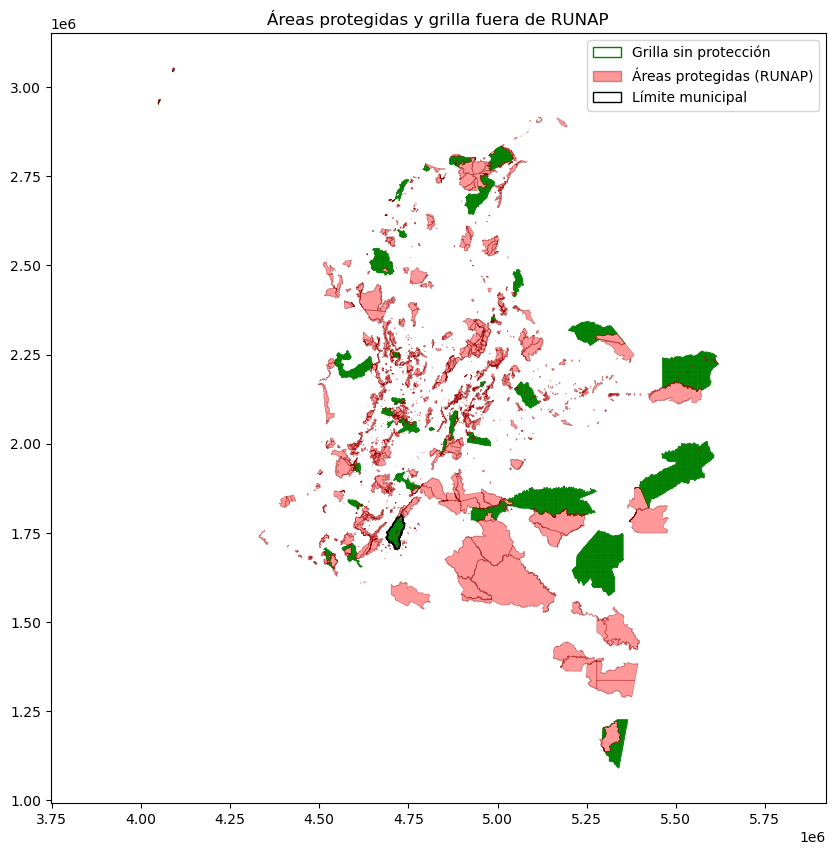

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

# 1. Grilla sin áreas protegidas (final válida)
grid_fina_no_protegida.plot(ax=ax, color='white', edgecolor='green', linewidth=0.3, label='Grilla sin protección')

# 2. Áreas protegidas RUNAP
runap_in_mun.plot(ax=ax, color='red', alpha=0.4, edgecolor='darkred', linewidth=0.5, label='Áreas protegidas (RUNAP)')

# 3. Límite del municipio
mun_sel.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, label='Mun_sel_general')

# Zoom automático
xmin, ymin, xmax, ymax = mun_sel.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Leyenda personalizada
legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor='green', label='Grilla sin protección'),
    mpatches.Patch(facecolor='red', edgecolor='darkred', label='Áreas protegidas (RUNAP)', alpha=0.4),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Límite municipal'),
]

ax.legend(handles=legend_elements, loc='upper right')
plt.title("Áreas protegidas y grilla fuera de RUNAP")
plt.axis('equal')
plt.show()

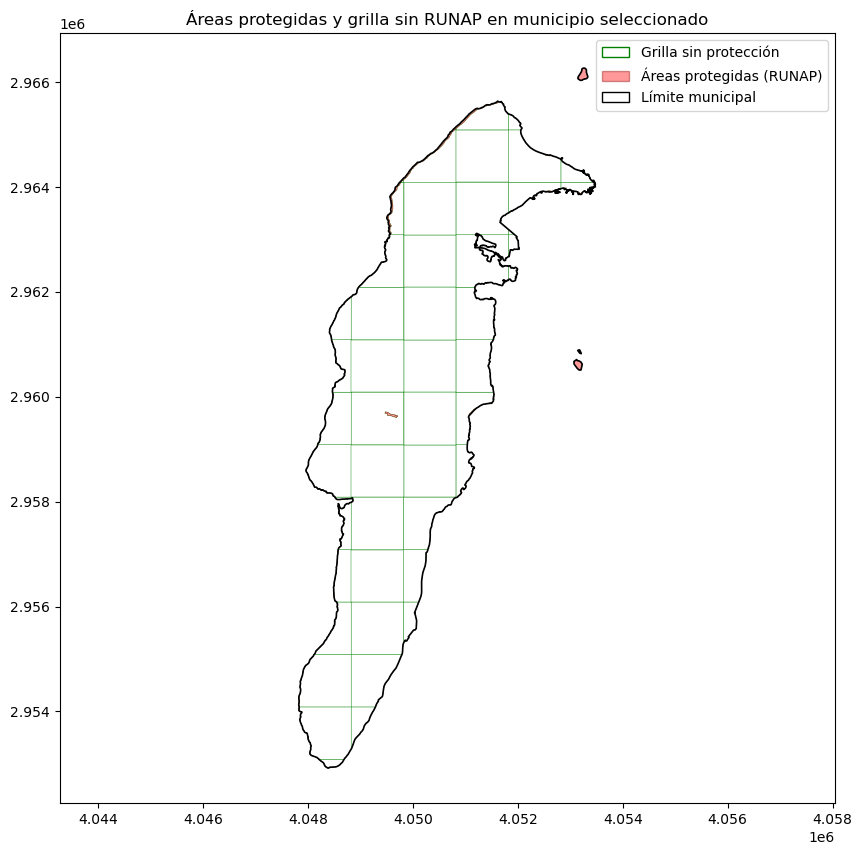

In [83]:
# 1. Recortar RUNAP al municipio seleccionado
runap_mun_sel_general = gpd.overlay(
    gdf_runap,
    mun_sel,
    how='intersection',
    keep_geom_type=False
)

# Filtrar solo polígonos válidos
runap_mun_sel_general = runap_mun_sel_general[
    runap_mun_sel_general.geometry.type.isin(['Polygon', 'MultiPolygon'])
].reset_index(drop=True)

# 2. Recortar la grilla sin protección al municipio
grilla_mun_sel_no_protegida = gpd.overlay(
    grid_fina_no_protegida,
    mun_sel,
    how='intersection',
    keep_geom_type=False
)

# Filtrar solo celdas con geometría válida
grilla_mun_sel_no_protegida = grilla_mun_sel_no_protegida[
    grilla_mun_sel_no_protegida.geometry.type.isin(['Polygon', 'MultiPolygon'])
].reset_index(drop=True)

# 3. Graficar
fig, ax = plt.subplots(figsize=(10, 10))

# Grilla sin protección dentro del municipio
grilla_mun_sel_no_protegida.plot(ax=ax, color='white', edgecolor='green', linewidth=0.3)

# Áreas protegidas RUNAP dentro del municipio
runap_mun_sel_general.plot(ax=ax, color='red', alpha=0.4, edgecolor='darkred', linewidth=0.5)

# Límite del municipio
mun_sel.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2)

# Zoom al municipio
xmin, ymin, xmax, ymax = mun_sel.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Leyenda personalizada
legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor='green', label='Grilla sin protección'),
    mpatches.Patch(facecolor='red', edgecolor='darkred', label='Áreas protegidas (RUNAP)', alpha=0.4),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Límite municipal')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.title("Áreas protegidas y grilla sin RUNAP en municipio seleccionado")
plt.axis('equal')
plt.show()


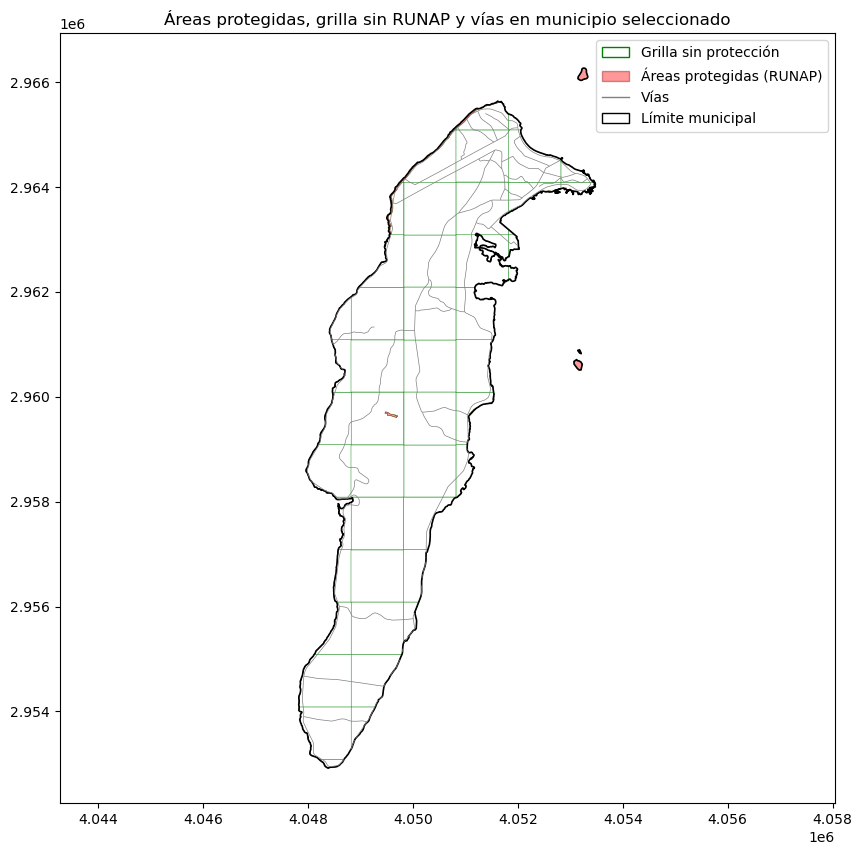

In [84]:
# 1. Recortar RUNAP al municipio seleccionado
runap_mun_sel_general = gpd.overlay(
    gdf_runap,
    mun_sel,
    how='intersection',
    keep_geom_type=False
)

# Filtrar solo polígonos válidos
runap_mun_sel_general = runap_mun_sel_general[
    runap_mun_sel_general.geometry.type.isin(['Polygon', 'MultiPolygon'])
].reset_index(drop=True)

# 2. Recortar la grilla sin protección al municipio
grilla_mun_sel_no_protegida = gpd.overlay(
    grid_fina_no_protegida,
    mun_sel,
    how='intersection',
    keep_geom_type=False
)

# Filtrar solo celdas con geometría válida
grilla_mun_sel_no_protegida = grilla_mun_sel_no_protegida[
    grilla_mun_sel_no_protegida.geometry.type.isin(['Polygon', 'MultiPolygon'])
].reset_index(drop=True)

# 3. Recortar vías al municipio seleccionado
vias_mun_sel = gpd.overlay(
    gdf_vias,
    mun_sel,
    how='intersection'
)

# 4. Graficar todo
fig, ax = plt.subplots(figsize=(10, 10))

# Grilla sin protección
grilla_mun_sel_no_protegida.plot(ax=ax, color='white', edgecolor='green', linewidth=0.3, label='Grilla sin protección')

# Áreas protegidas RUNAP
runap_mun_sel_general.plot(ax=ax, color='red', alpha=0.4, edgecolor='darkred', linewidth=0.5, label='Áreas protegidas')

# Vías
vias_mun_sel.plot(ax=ax, color='gray', linewidth=0.5, label='Vías')

# Límite del municipio
mun_sel.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, label='Límite municipal')

# Ajuste de zoom
xmin, ymin, xmax, ymax = mun_sel.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Leyenda personalizada
legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor='green', label='Grilla sin protección'),
    mpatches.Patch(facecolor='red', edgecolor='darkred', label='Áreas protegidas (RUNAP)', alpha=0.4),
    Line2D([0], [0], color='gray', lw=1, label='Vías'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Límite municipal')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.title("Áreas protegidas, grilla sin RUNAP y vías en municipio seleccionado")
plt.axis('equal')
plt.show()


In [85]:
# Obtener límites de Colombia a partir del shapefile de municipios
bounds = gdf_mun.total_bounds
xmin, ymin, xmax, ymax = bounds

# Definir resolución de la grilla (100 km)
res = 100000  # en metros

# Crear listas de coordenadas para columnas y filas
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax + res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax + res)), res))
rows.reverse()  # Para que vaya de norte a sur

# Crear celdas de la grilla como polígonos
grid_polygons = []
for x in cols:
    for y in rows:
        poly = Polygon([
            (x, y),
            (x + res, y),
            (x + res, y - res),
            (x, y - res)
        ])
        grid_polygons.append(poly)

# Crear GeoDataFrame de la grilla
grid = gpd.GeoDataFrame({'geometry': grid_polygons}, crs=gdf_mun.crs)

# Filtrar grilla: solo celdas que intersectan con algún municipio
grid = grid[grid.intersects(gdf_mun.union_all())].copy()

# Agregar ID único
grid.reset_index(drop=True, inplace=True)
grid["grid_id"] = grid.index + 1  # Opcional: iniciar en 1

print(f"Grilla final: {len(grid)} celdas de {res/1000} km de lado que intersectan con municipios.")
grid.head()


Grilla final: 159 celdas de 100.0 km de lado que intersectan con municipios.


,geometry,grid_id
0,"POLYGON ((4047822 3090086, 4147822 3090086, 41...",1
1,"POLYGON ((4047822 2990086, 4147822 2990086, 41...",2
2,"POLYGON ((4247822 1790086, 4347822 1790086, 43...",3
3,"POLYGON ((4347822 1890086, 4447822 1890086, 44...",4
4,"POLYGON ((4347822 1790086, 4447822 1790086, 44...",5


### 4.2 - Calcular criterios locales (distancia a vías, estaciones, densidad poblacional)

In [19]:
from shapely.strtree import STRtree

# 1. Lista de geometrías
vias_geoms = list(gdf_vias.geometry)
est_geoms = list(gdf_est.geometry)
print(f"Geometrías cargadas: {len(vias_geoms)} vías, {len(est_geoms)} estaciones")

# 2. Crear árbol espacial
vias_tree = STRtree(vias_geoms)
est_tree = STRtree(est_geoms)

# 3. Calcular centroides de las celdas
centroids = grid_fina.geometry.centroid
print(f"Centroides calculados para {len(centroids)} celdas.")

# 4. Función de distancia mínima desde un punto a geometrías en un árbol
def min_dist_to_tree(point, tree, geoms):
    idxs = tree.query(point)
    if len(idxs) == 0:
        return np.nan
    return min(point.distance(geoms[i]) for i in idxs)

# 5. Aplicar distancias usando los árboles espaciales
grid_fina['dist_vias'] = [min_dist_to_tree(pt, vias_tree, vias_geoms) for pt in centroids]
grid_fina['dist_est'] = [min_dist_to_tree(pt, est_tree, est_geoms) for pt in centroids]

# Vista previa
print(grid_fina[['dist_vias', 'dist_est']].head())

Geometrías cargadas: 108228 vías, 8973 estaciones
Centroides calculados para 113741 celdas.
    dist_vias  dist_est
0   67.856810       NaN
1  346.108741       NaN
2   54.701617       NaN
3  117.892322       NaN
4  128.283111       NaN


### 4.3 - Normalización y selección de mejor celda

In [20]:
grid_fina[['c1_vias', 'c2_estaciones', 'c3_poblacion']] = MinMaxScaler().fit_transform(
    pd.DataFrame({
        'c1_vias': -grid_fina['dist_vias'],
        'c2_estaciones': -grid_fina['dist_est'],
        'c3_poblacion': -grid_fina['pop_density']
    }))

grid_fina['SCORE_LOCAL'] = (
    0.4 * grid_fina['c1_vias'] +
    0.3 * grid_fina['c2_estaciones'] +
    0.3 * grid_fina['c3_poblacion'])

best_cell = grid_fina.sort_values('SCORE_LOCAL', ascending=False).head(1)

/opt/miniconda/lib/python3.11/site-packages/sklearn/utils/_array_api.py:701: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/opt/miniconda/lib/python3.11/site-packages/sklearn/utils/_array_api.py:718: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


## Visualización final

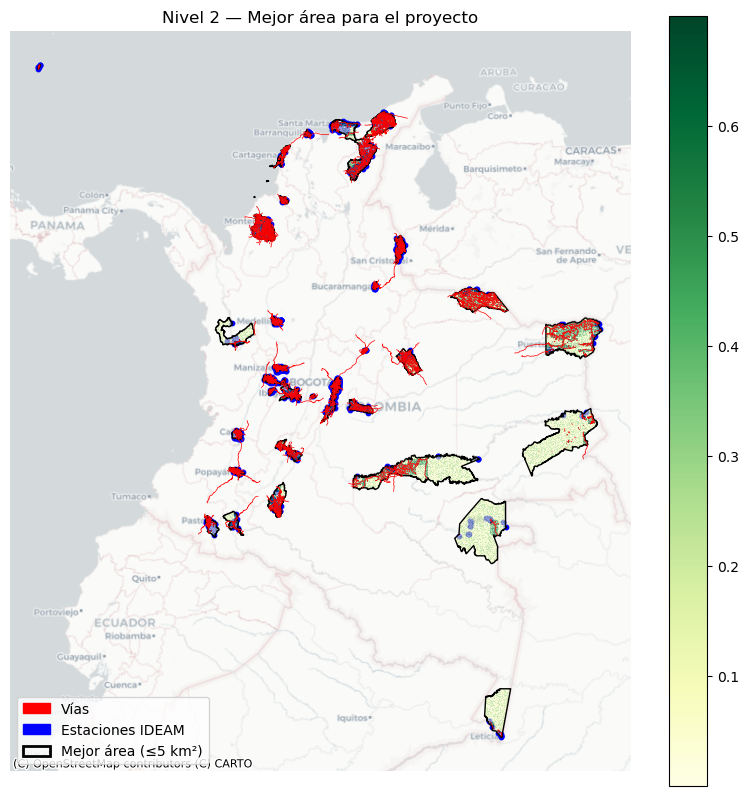

In [152]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

# Ploteo
mun_sel.boundary.plot(ax=ax, color='black', linewidth=1)
vias_mun.plot(ax=ax, color='red', linewidth=0.5)
est_mun.plot(ax=ax, color='blue', markersize=10)
grid_fina.plot(ax=ax, column='SCORE_LOCAL', cmap='YlGn', alpha=0.6, legend=True)
best_cell.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)

# Basemap
ctx.add_basemap(ax, crs=mun_sel.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Título
plt.title("Nivel 2 — Mejor área para el proyecto")
plt.axis('off')

# Leyenda personalizada
custom_legend = [
    mpatches.Patch(color='red', label='Vías'),
    mpatches.Patch(color='blue', label='Estaciones IDEAM'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Mejor área (≤5 km²)', linewidth=2)
]
plt.legend(handles=custom_legend, loc='lower left')

plt.show()


NameError: name 'vias_mun' is not defined

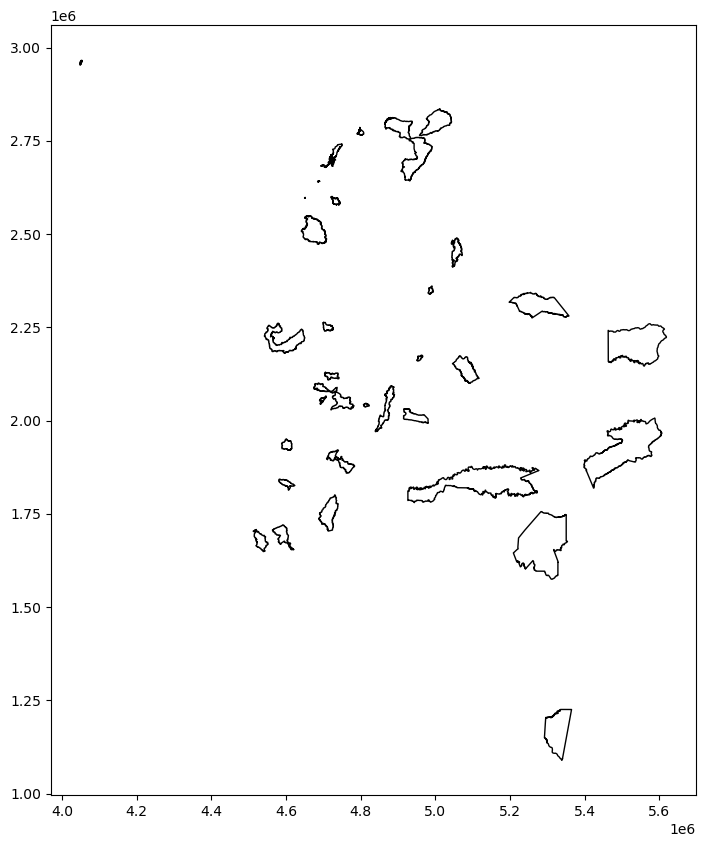

In [21]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

# Ploteo
mun_sel.boundary.plot(ax=ax, color='black', linewidth=1)
vias_mun.plot(ax=ax, color='red', linewidth=0.5)
est_mun.plot(ax=ax, color='blue', markersize=10)
grid_fina.plot(ax=ax, column='SCORE_LOCAL', cmap='YlGn', alpha=0.6, legend=True)
best_cell.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)

# Basemap
ctx.add_basemap(ax, crs=mun_sel.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Título
plt.title("Nivel 2 — Mejor área para el proyecto")
plt.axis('off')

# Leyenda personalizada
custom_legend = [
    mpatches.Patch(color='red', label='Vías'),
    mpatches.Patch(color='blue', label='Estaciones IDEAM'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Mejor área (≤5 km²)', linewidth=2)
]
plt.legend(handles=custom_legend, loc='lower left')

plt.show()

In [153]:
# Filtrar municipios que tengan al menos algún valor en todos los criterios
mun_validos = mun_scores[
    (mun_scores['ideam_count'] > 0) &
    (mun_scores['length_m'] > 0) &
    (mun_scores['avocado_prod_ton'] > 0) &
    (mun_scores['population_part'] > 0)
]


In [154]:
# Ordenar por SCORE descendente
mejor_municipio = mun_validos.sort_values('SCORE', ascending=False).head(1)

# Mostrar el resultado
display(mejor_municipio[['MPIO_CCDGO', 'MPIO_CNMBR', 'SCORE']])


,MPIO_CCDGO,MPIO_CNMBR,SCORE


In [155]:
condiciones = [
    mun_scores['ideam_count'] > 0,
    mun_scores['length_m'] > 0,
    mun_scores['avocado_prod_ton'] > 0,
    mun_scores['population_part'] > 0
]

# Sumar condiciones verdaderas por municipio
mun_scores['condiciones_validas'] = sum(condiciones)

# Filtrar municipios con al menos 3 condiciones cumplidas
mun_validos = mun_scores[mun_scores['condiciones_validas'] >= 3]


In [156]:
mejor_municipio = mun_validos.sort_values('SCORE', ascending=False).head(1)
display(mejor_municipio[['MPIO_CCDGO', 'MPIO_CNMBR', 'SCORE']])


,MPIO_CCDGO,MPIO_CNMBR,SCORE
628,00001,SAN ANDRÉS,0.75


In [157]:
print("Con estaciones:", (mun_scores['ideam_count'] > 0).sum())
print("Con vías:", (mun_scores['length_m'] > 0).sum())
print("Con producción de avocado:", (mun_scores['avocado_prod_ton'] > 0).sum())
print("Con población estimada:", (mun_scores['population_part'] > 0).sum())


Con estaciones: 1101
Con vías: 1118
Con producción de maíz: 0
Con población estimada: 1122


In [158]:
# Extraer geometría y datos del municipio final
municipio_final = gdf_mun[gdf_mun["MPIO_CCDGO"] == mejor_municipio.iloc[0]["MPIO_CCDGO"]]
